# Limitations of Stationary Kernels
Mark van der Wilk, 3 Feb 2023

Many common kernels are stationary. 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import gpflow
import itertools
from tools import datasets
from tools import plotting
import abc

np.random.seed(0)

2023-02-03 14:53:19.889890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# sX = np.vstack((np.random.exponential(size=(25, 1)), -np.random.exponential(size=(25, 1)), [[10], [-3]])) * 0.5
sX = np.vstack((
    np.random.exponential(size=(35, 1)) * 0.2,
    -np.random.exponential(size=(35, 1)) * 0.2,
    np.random.rand(25, 1) * 8 - 4
    # np.linspace(25, -4, 4)[:, None]
))
sX = sX[np.random.permutation(len(sX)), :]

In [3]:
def easy(X):
    return 0.5 * np.sin(X * 3.0)

def hard(X):
    return easy(X) + (X > 0.0).astype('float') - 0.5

In [4]:
sY = easy(sX) + np.random.randn(*sX.shape) * 2e-2
sY_step = hard(sX) + np.random.randn(*sX.shape) * 2e-2
pX = np.linspace(-6, 6, 600)[:, None]

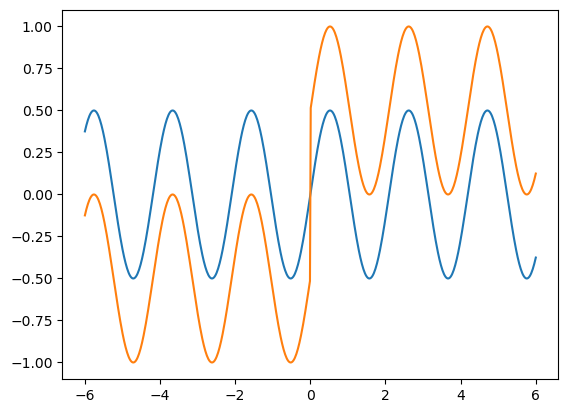

In [5]:
plt.plot(pX, easy(pX))
plt.plot(pX, hard(pX))

2023-02-03 14:53:29.779607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


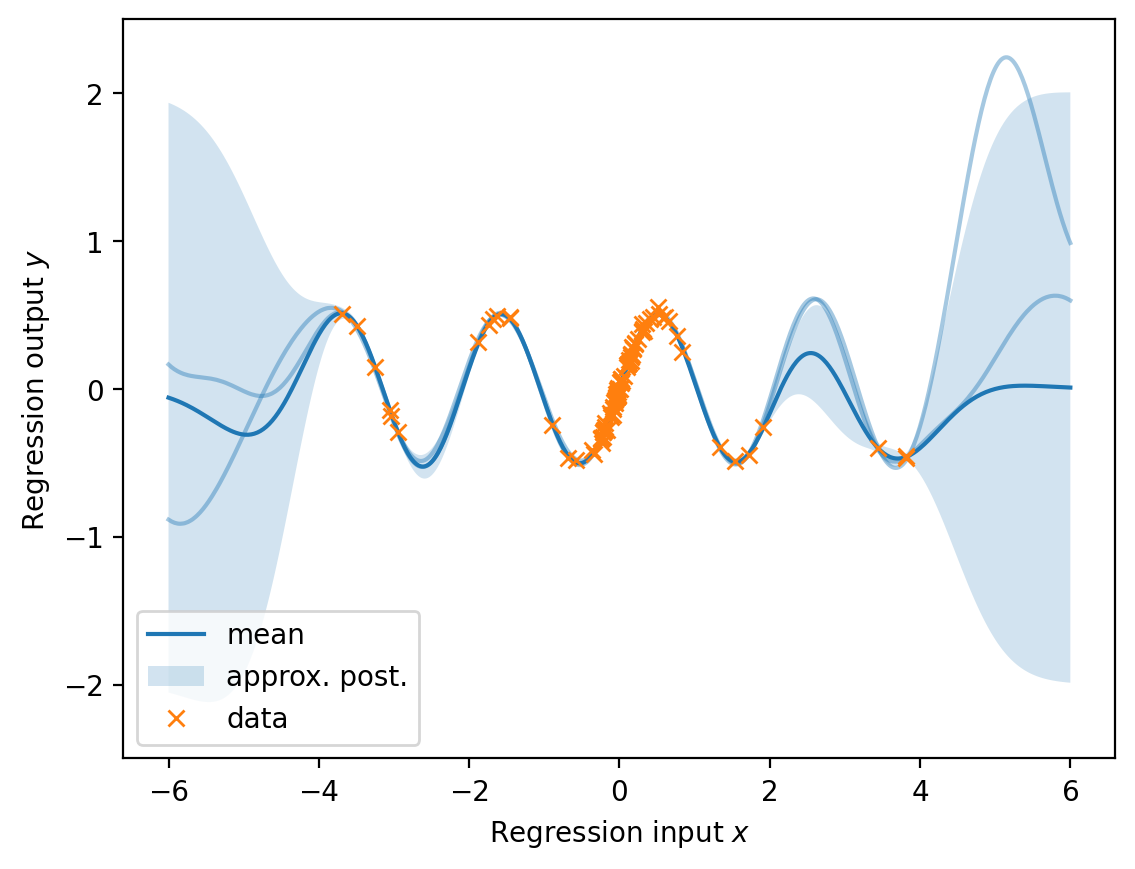

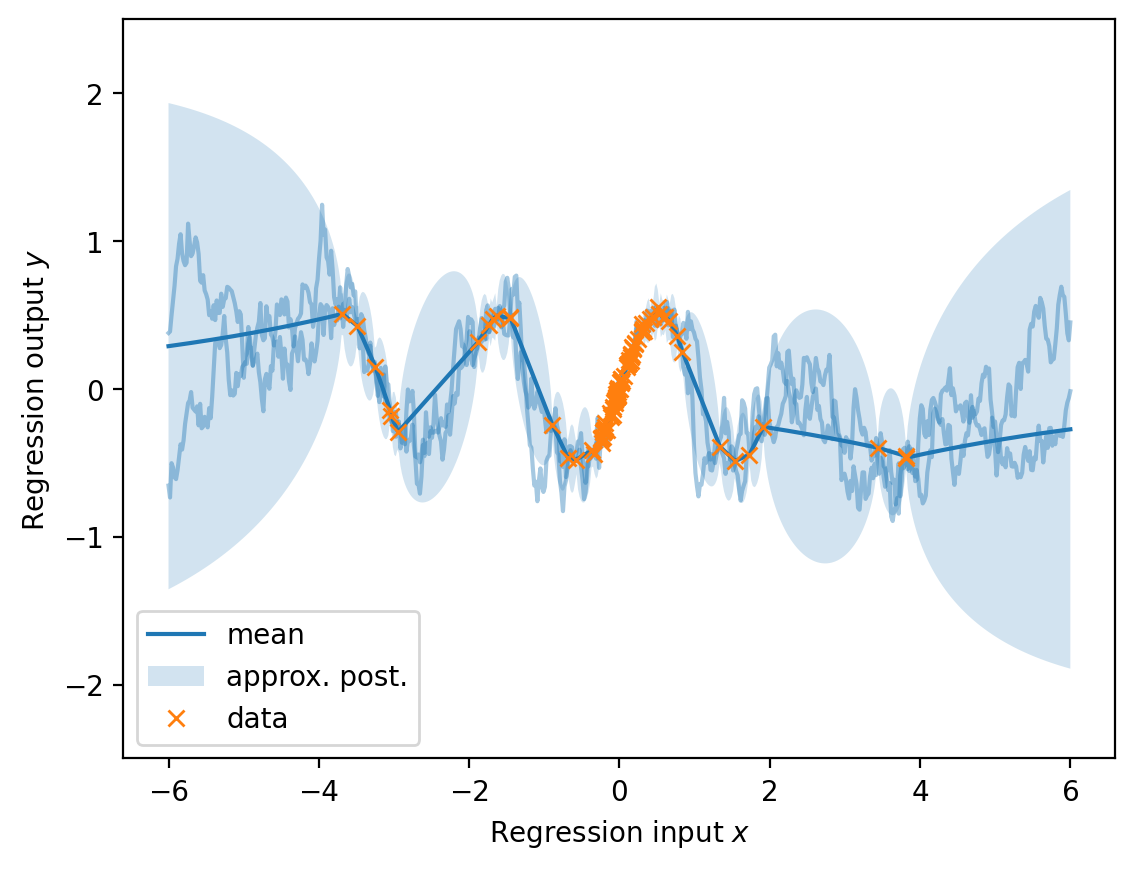

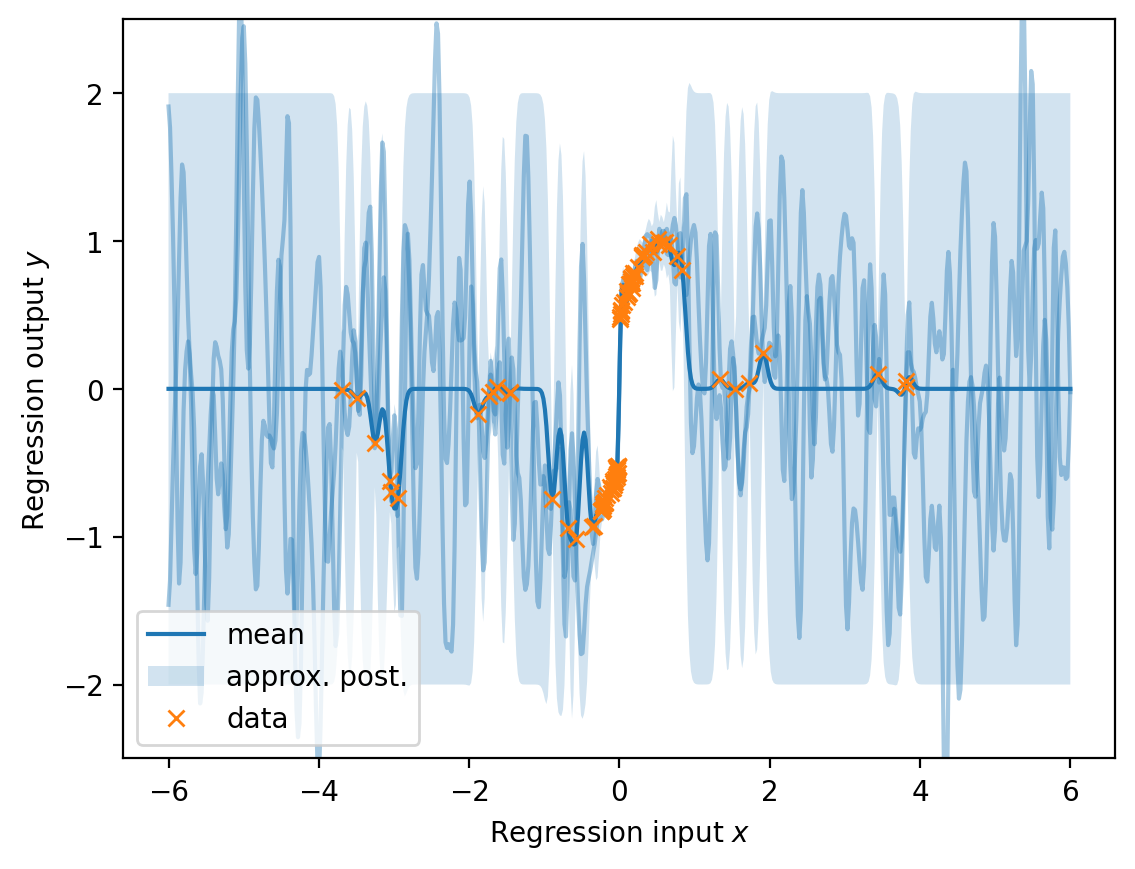

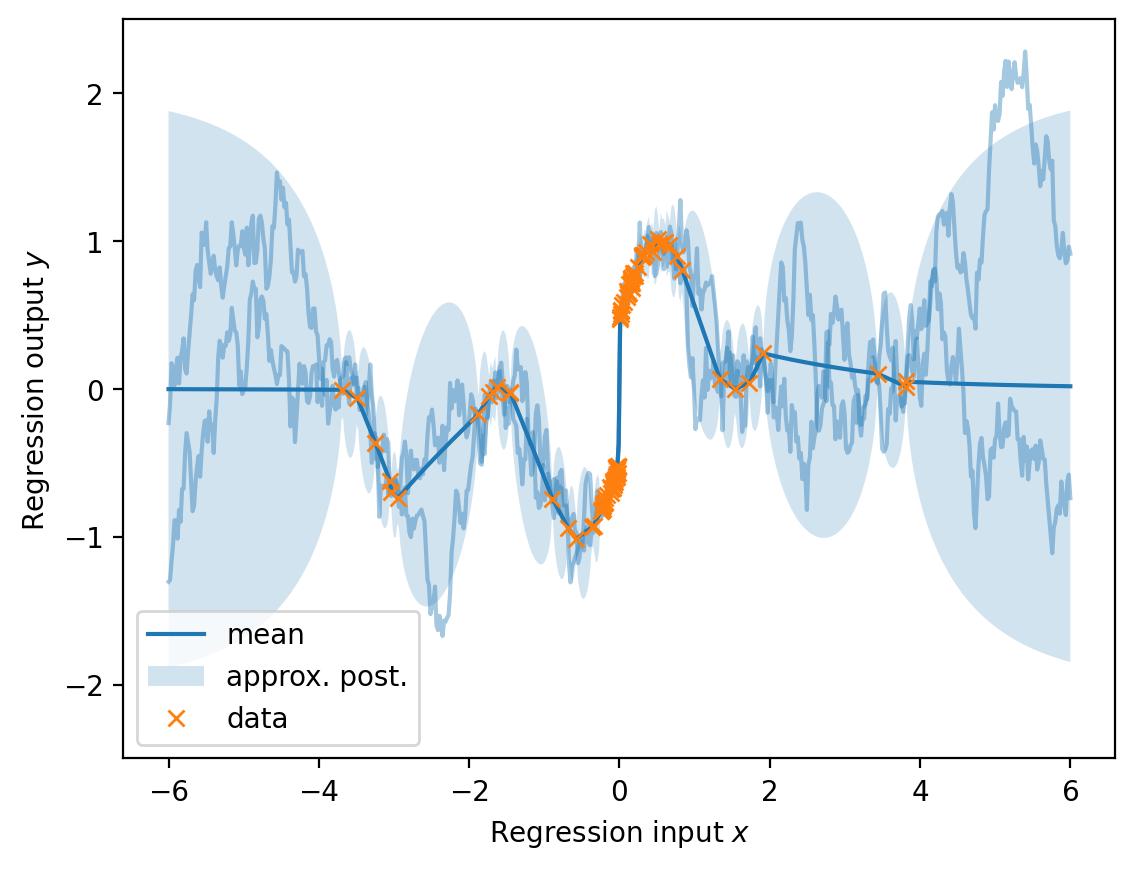

In [6]:
for dataset, kern in itertools.product(
    [(sX, sY), (sX[:, :], sY_step[:, :])],
    # [gpflow.kernels.SquaredExponential, gpflow.kernels.Matern52, gpflow.kernels.Matern32, gpflow.kernels.Matern12],
    [gpflow.kernels.SquaredExponential, gpflow.kernels.Matern12]
):
    X, Y = dataset
    fullm = gpflow.models.GPR((X, Y), kern())
    gpflow.set_trainable(fullm.kernel.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(fullm.training_loss, variables=fullm.trainable_variables)
    lml = fullm.log_marginal_likelihood()
    full_pY, full_pYv = fullm.predict_f(pX)
    
    fig, axs = plt.subplots(1, 1, dpi=200)
    axs = [axs]
    plotting.plot_1d_model(fullm, pX=pX, plot_var='f', plot_samples=True, plot_mean=True, ax=axs[0], plot_samples_z=np.random.randn(len(pX), 2))

    # axs[0].set_xlim(-5, 5)
    axs[0].set_ylim(-2.5, 2.5)
    axs[0].set_xlabel("Regression input $x$")
    axs[0].set_ylabel("Regression output $y$")
    axs[0].legend(loc='lower left')